<a href="https://colab.research.google.com/github/leeh8911/Deep_Learning_from_Scratch_Study/blob/master/Chapter6_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# chapter6. Technique about learning
1. backpropagation method
2. weight initial value
3. batch normalization
4. restrain overfitting
5. hyper-parameter optimization


In [88]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

import sys, os
os.chdir("/content/gdrive/My Drive/github/deep-learning-from-scratch/ch05")
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

import numpy as np
import matplotlib.pylab as plt
from collections import OrderedDict 
from IPython.display import clear_output

%matplotlib inline

print("env setting finished!")



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
env setting finished!


In [89]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten = True, normalize = True, one_hot_label = True)

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [0]:

    
    
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a

    return y

def cross_entropy_error(y, t):
    delta = 1e-7
    
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + delta)) / batch_size


class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1/(1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out)*self.out
        
        return dx
    
    
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx
    
class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [0]:
# costomized network
class cosNet:
    def __init__(self, input_size = 1, hidden_size = 1, output_size = 1, weight_init_std = 0.01):
        
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
                Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Affine2'] = \
                Affine(self.params['W2'], self.params['b2']);
        
        self.lastLayer = SoftmaxWithLoss()
        
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        
        if t.ndim != 1 : t = np.argmax(t, axis = 1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads
    
    def display(self):
        clear_output()
        plt.figure(1)
        plt.title("Network")
        plt.show()
        return False
        

In [0]:
# backpropagation methods
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
            
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys():
                self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
                params[key] += self.v
                
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
        for key, val in params.item():
            self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            slef.h[key] += grads[key]*grads[key]
            params[key] -= self.lr*grads[key]/np.sqrt(self.h[key] + 1e-7)
            
            
def sigmoid(x):
    return 1 / (1 + np.exp(-x))



In [100]:
net = cosNet(input_size = x_train.shape[1], hidden_size = 50, output_size = 10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = net.gradient(x_batch, t_batch)
    
    for key in ('W1','b1','W2','b2'):
        net.params[key] -= learning_rate * grad[key]
        
    loss = net.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = net.accuracy(x_train, t_train)
        test_acc = net.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

        


784 50 10 0.01
0.12131666666666667 0.1303
0.10218333333333333 0.101
0.09871666666666666 0.098
0.09871666666666666 0.098


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in less_equal


0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098
0.09871666666666666 0.098


KeyboardInterrupt: ignored

(-0.1, 1.1)

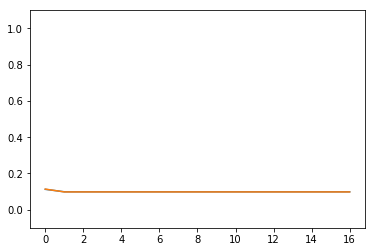

In [94]:

plt.figure(2)
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.ylim([-0.1, 1.1])